# Practica VI - Data Exploration Part 6

Planejamento de Experimentos
_ _ _
___
_ _ _


## 1.- Data - Boston House Pricing

### 1.1.- Retrieving Data

#### 1.1.1.- Reading Data

In [7]:
try :
    boston_dataset = pd.read_csv("./boston/housing.data", sep="\t", header=None)
    boston_dataset.columns = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]
except:
    print("ERROR, DATA NOT LOADED")
else:
    print("""DATA SUCCESSFULLY LOADED\n
    \tRows\t:\t{:d}\t|\tColumns\t:\t{:d}""".format(boston_dataset.shape[0], boston_dataset.shape[1]))

DATA SUCCESSFULLY LOADED

    	Rows	:	506	|	Columns	:	14


#### 1.1.2.- Data Labels
0. **CRIM**      :  *per capita crime rate by town*
2. **ZN**        :  *proportion of residential land zoned for lots over 25,000 sq.ft.*
3. **INDUS**     :  *proportion of non-retail business acres per town*
4. **CHAS**      :  *Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)*
5. **NOX**       :  *nitric oxides concentration (parts per 10 million)*
6. **RM**        :  *average number of rooms per dwelling*
7. **AGE**       :  *proportion of owner-occupied units built prior to 1940*
8. **DIS**       :  *weighted distances to five Boston employment centres*
9. **RAD**       :  *index of accessibility to radial highways*
10. **TAX**      :  *full-value property-tax rate per \$10 000*
11. **PTRATIO**  :  *pupil-teacher ratio by town*
12. **B**        :  *1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town*
13. **LSTAT**    :  *\% lower status of the population*
14. **MEDV**     :  *Median value of owner-occupied homes in \$1000's*

#### 1.1.3.- Basic Data Exploration

In [8]:
boston_dataset.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273.0,21.0,396.90,7.88,11.9


In [9]:
case_data_Boston = boston_dataset.copy()
del boston_dataset

### 1.2 Atributes Conversion (PreProcessing)

High    255
Low     251
Name: target, dtype: int64

array(['High', 'Low'], dtype=object)

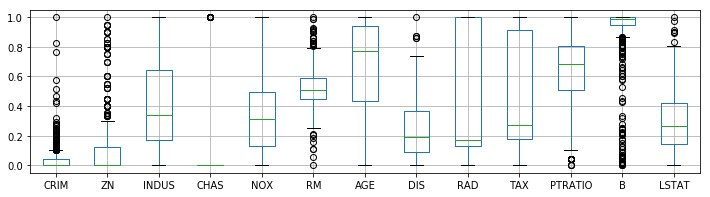

In [10]:
## Creating Targets

targets = p_plt.make_targets(case_data_Boston.MEDV, samples=2, labels=["Low", "High"])

case_data_Boston.drop(columns=["MEDV"], inplace=True)
case_data_Boston["target"] = targets

display(case_data_Boston.target.value_counts())

target = case_data_Boston.target.copy()
case_data_Boston.drop(columns=["target"], inplace=True)

## Resizing

t__ = case_data_Boston.TAX
t__ = (t__ - t__.min()) / (t__.max() - t__.min())
t__ = t__ * 100
case_data_Boston.TAX = t__.values.copy()

t__ = case_data_Boston.B
t__ = (t__ - t__.min()) / (t__.max() - t__.min())
t__ = t__ * 100

case_data_Boston.B = t__.values.copy()

case_data_Boston = (case_data_Boston - case_data_Boston.min()) / (case_data_Boston.max() - case_data_Boston.min())

case_data_Boston.boxplot(figsize=(12,3))

## Binarizing Targets

lbl = preprocessing.LabelEncoder()
lbl.fit(target)
display(lbl.classes_)
target_vanilla = lbl.transform(target)

boston = case_data_Boston.copy()
boston["target"] = target_vanilla

del case_data_Boston

#### 1.2.1 PCA and Atributes to Use

In [11]:
eigvals, eigvect = np.linalg.eig(boston[boston.columns.tolist()[:-1]].cov())

eigvect = pd.DataFrame(eigvect, index=boston.columns.tolist()[:-1], columns=boston.columns.tolist()[:-1])

eigvals = (eigvals / eigvals.sum()) * 100
eigvals = pd.DataFrame(eigvals, index=boston.columns.tolist()[:-1], 
             columns=["relevance"]).sort_values(by="relevance", ascending=True)

In [12]:
rel_ = eigvals.cumsum().sort_values(by="relevance", ascending=False)
display(rel_[rel_.relevance > 10])

pca_colums = rel_[rel_.relevance > 10].index.tolist()

,relevance
CRIM,100.000000
ZN,46.530759
INDUS,33.985159
CHAS,25.446529
NOX,19.184885
RM,14.279260
AGE,10.509197


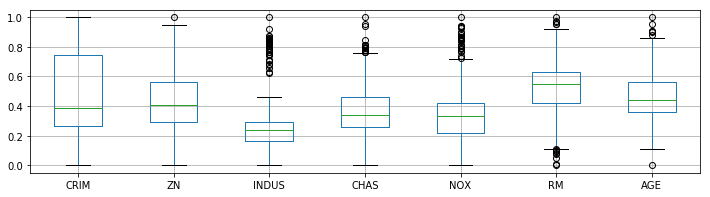

In [13]:
### Aplying PCA

temp = np.dot(
    eigvect[pca_colums].values.T, 
    boston[boston.columns.tolist()[:-1]].values.T).T

temp = pd.DataFrame(temp, columns=pca_colums)
temp = (temp - temp.min()) / (temp.max() - temp.min())
temp.boxplot(figsize=(12,3))

temp["target"] = boston.target

boston = temp

### 1.3 Sub Amostragem | Super Amostragem

In [14]:
def mostragem(df_data, amount, prob=None):
    if prob is None:
        prob = df_data.target.value_counts() / df_data.target.value_counts().sum()
    else:
        pass
    
    output = []
    for ii in df_data.target.unique():
        target = df_data.target
        output += [df_data.loc[target == ii].sample(n=int(amount * prob[ii]), replace=True)]

    output = pd.concat(output)

    print("{:d} samples".format(amount))
    display(output.target.value_counts())
    
    return output

In [15]:
## Sub Amostragem (200)

_200_boston = mostragem(boston, 200)

## Re-indexing
_200_boston.index = np.arange(_200_boston.target.count())

## Super Amostragrem (2000)

_2000_boston = mostragem(boston, 2000)
_2000_boston.index = np.arange(_2000_boston.target.count())

200 samples


0    100
1     99
Name: target, dtype: int64

2000 samples


0    1007
1     992
Name: target, dtype: int64

**elas tem a mesma probabilidade por classe?**

sim, quase a mesma probabilidade

In [16]:
def prob_per_class(df_data):
    prob = df_data.target.value_counts() / df_data.target.value_counts().sum()
    return prob

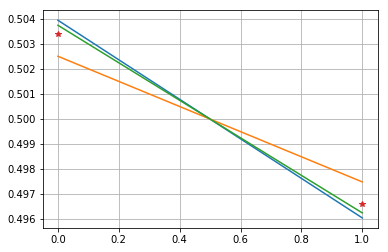

In [17]:
plt.grid()

comp_prob = pd.DataFrame()
comp_prob["Base"] = prob_per_class(boston).values
comp_prob["Sub200"] = prob_per_class(_200_boston).values 
comp_prob["Super2000"] = prob_per_class(_2000_boston).values

for colm in comp_prob.columns.tolist():
    plt.plot(comp_prob[colm])
    
plt.plot(comp_prob.mean(axis=1), "*")

In [18]:
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import label_binarize

In [19]:
def meta_aval(dataset, columns, target, medias_aval, folds=-1, function_class=classificacao):
    output = {}
    if folds == -1:
        for aval_name, med_aval in medias_aval.items():
            output[aval_name] = function_class(dataset, columns, target, med_aval, aval_name)
    else:
        for aval_name, med_aval in medias_aval.items():
            output[aval_name] = function_class(dataset, columns, target, med_aval, aval_name, folds=folds)
    
    return output

In [20]:
medias_aval = {'conf_mtrx': confusion_matrix}

target = len(boston.columns) - 1
columns = list(range(target))

print(columns)
print(target)

[0, 1, 2, 3, 4, 5, 6]
7


### 1.4.- 10 Fold , Leave One Out and Bootstrap

#### 1.4.1.- 10 Fold

In [21]:
folds = 10

raw_10_fold = meta_aval(boston, columns, target, medias_aval, folds=folds)
_200_10_fold  = meta_aval(_200_boston, columns, target, medias_aval, folds=folds)
_2000_10_fold = meta_aval(_2000_boston, columns, target, medias_aval, folds=folds)

#### 1.4.2 Leave One Out

In [ ]:
raw_one_out = meta_aval(boston, columns, target, medias_aval, folds=boston.target.count())
_200_one_out = meta_aval(_200_boston, columns, target, medias_aval, folds=_200_boston.target.count())
_2000_one_out = meta_aval(_2000_boston, columns, target, medias_aval, folds=_2000_boston.target.count())

#### 1.4.3 Bootstrap

In [ ]:
N_btp_samples = 1000

N_samples = boston.shape[0]
bootstrap_dts = [boston.sample(n=N_samples, replace=True) for i in range(N_btp_samples)]
raw_bootstrap = meta_aval(bootstrap_dts, columns, target, medias_aval, function_class=classificacao_bootstrap)

In [ ]:
N_samples = _200_boston.shape[0]
bootstrap_dts = [_200_boston.sample(n=N_samples, replace=True) for i in range(N_btp_samples)]
_200_bootstrap = meta_aval(bootstrap_dts, columns, target, medias_aval, function_class=classificacao_bootstrap)

In [ ]:
N_samples = _2000_boston.shape[0]
bootstrap_dts = [_2000_boston.sample(n=N_samples, replace=True) for i in range(N_btp_samples)]
_2000_bootstrap = meta_aval(bootstrap_dts, columns, target, medias_aval, function_class=classificacao_bootstrap)

### 1.5.- Avaliation (10 Fold)

* **como em meio de tantas medias de avaliacao, comparar os classificadores?**

Como cada classificador usa uma técnica de validação de modelo diferente, é importante considerar o valor médio do total de resultados entre cada técnica de validação do modelo.

Então, estamos usando essas métricas de avaliação: taixa de falsos positivos (TFP) e taixa de falsos negativos (TFN) que tem que ser mínima, e por outro lado a taixa de verdadeiros negativos (TVN) e a taixa de verdadeiros positivos (TVP) quem tem que ser maxima.

Se usarmos a média das métricas (todas as métricas entre um mesmo tamanho de amostra), podemos ver uma imagem completa do desempenho das técnicas de classificação.

* como escolher o melhor?

Finalmente se, para cada tipo de amostra (normal, subamostragem e supersampling) as métricas entre cada método de classificação corresponderem ao ótimo (mínimo para as duas métricas e máximo para as outras) , poderia ser considerada a técnica de classificação com o score maior como a uma técnica bom suficiente


#### 1.5.1.- Normal Data

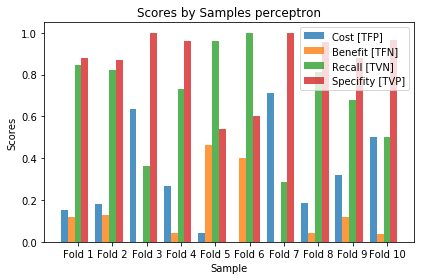

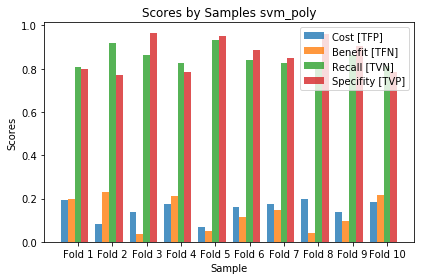

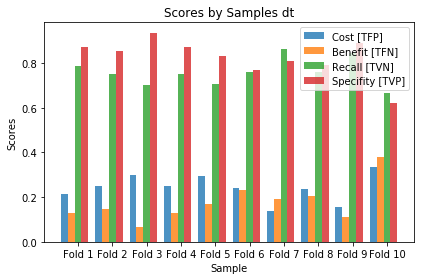

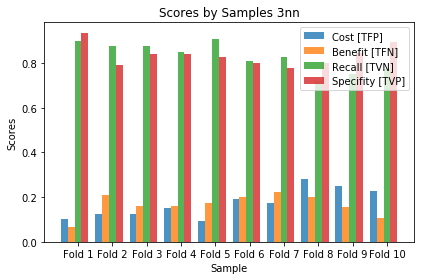

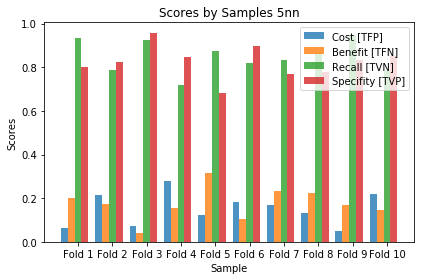

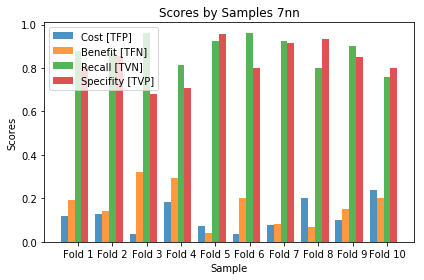

In [51]:
_10_fold_results = results_by_class(raw_10_fold["conf_mtrx"]["results"])
plot_results(_10_fold_results)

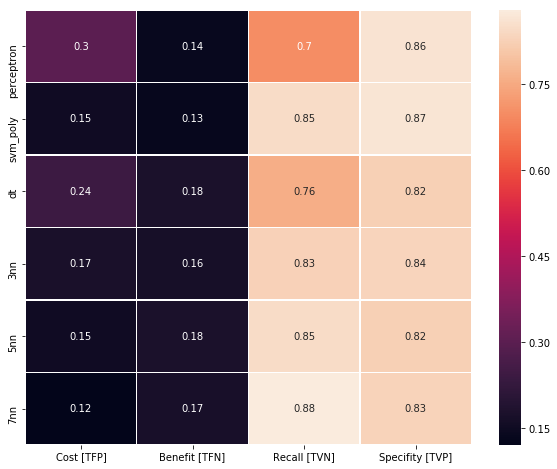

In [52]:
mean_normal = mean_plot_results(_10_fold_results)

#### 1.5.2.- 200 Sub Amostragem

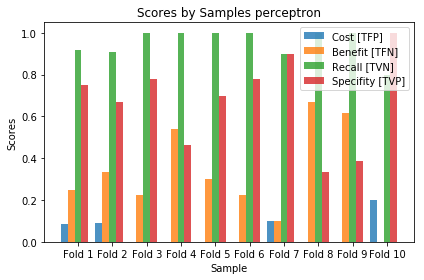

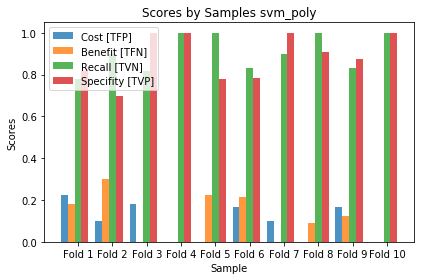

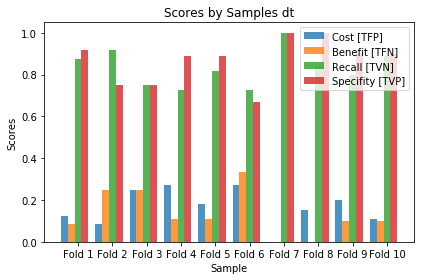

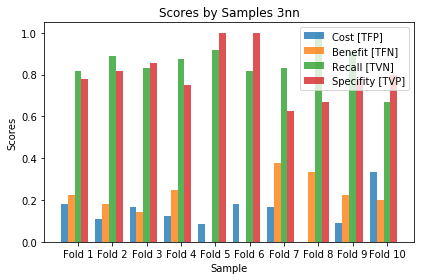

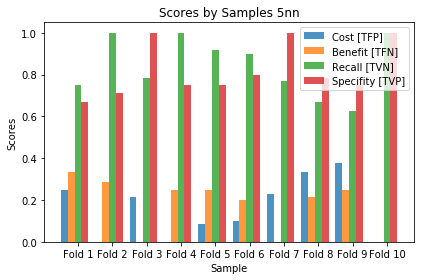

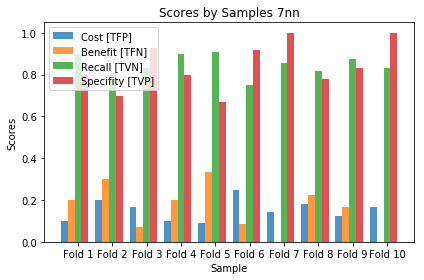

In [54]:
_200_10_fold_results = results_by_class(_200_10_fold["conf_mtrx"]["results"])
plot_results(_200_10_fold_results)

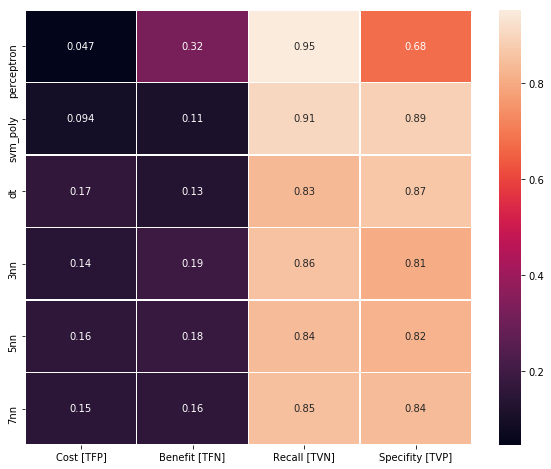

In [55]:
mean_200 = mean_plot_results(_200_10_fold_results)

#### 1.5.3.- 2000 Super Amostragem

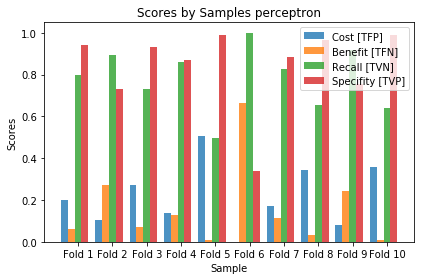

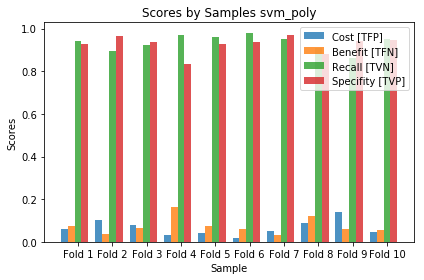

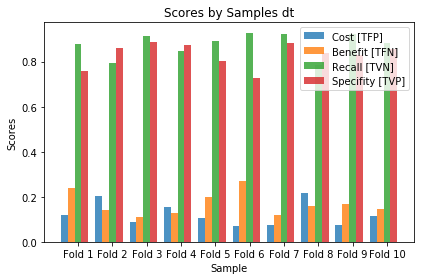

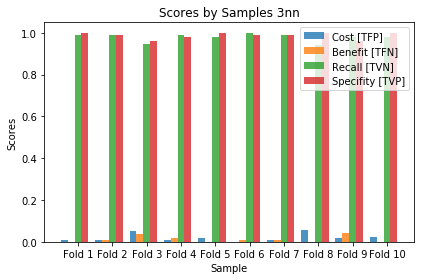

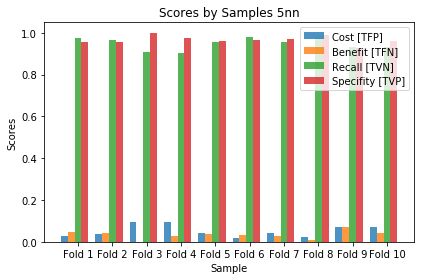

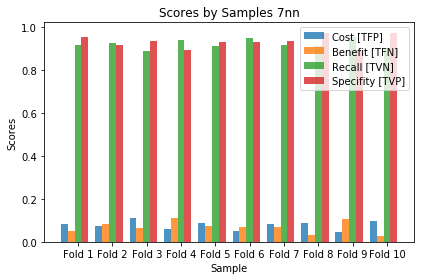

In [56]:
_2000_10_fold_results = results_by_class(_2000_10_fold["conf_mtrx"]["results"])
plot_results(_2000_10_fold_results)

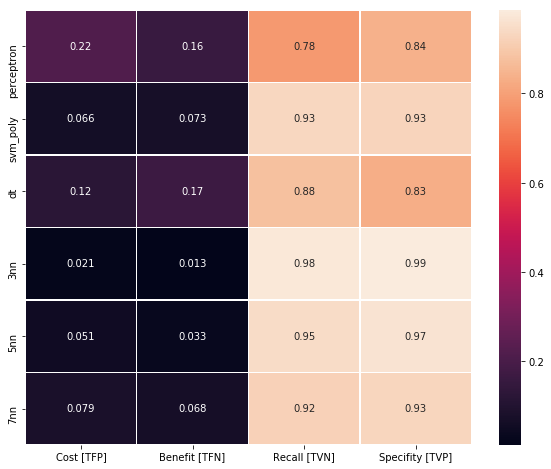

In [57]:
mean_2000 = mean_plot_results(_2000_10_fold_results)

#### 1.5.4 Mean

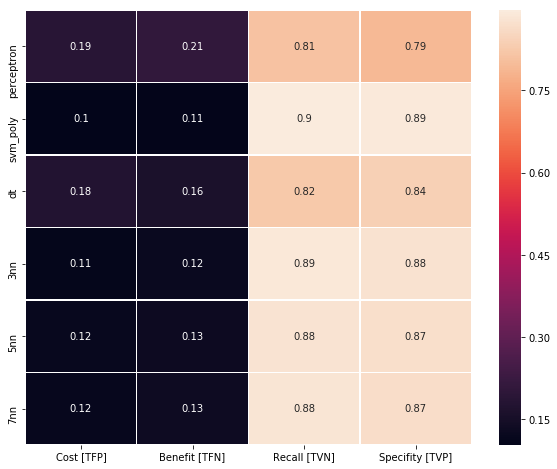

In [63]:
full_mean = (mean_normal + mean_200 + mean_2000) / 3

plt.figure(figsize=(10,8))
sns.heatmap(full_mean, annot=True, linewidths=.5)

In [89]:
whos_min = full_mean[full_mean.columns[:2]].idxmin()

print("Min TFP & TFN")
display(whos_min)

print("***********######***********")
whos_max = full_mean[full_mean.columns[2:]].idxmax()

print("Max TVN & TVP")
display(whos_max)
print("***********######***********")
print("classification technique score :\t ")
display(whos_min.append(whos_max).value_counts())
print(" of {:d} possible".format(full_mean.shape[1]))

Min TFP & TFN


Cost [TFP]       svm_poly
Benefit [TFN]    svm_poly
dtype: object

***********######***********
Max TVN & TVP


Recall [TVN]       svm_poly
Specifity [TVP]    svm_poly
dtype: object

***********######***********
classification technique score :	 


svm_poly    4
dtype: int64

 of 4 possible


Após avaliar cada técnica de classificação entre as métricas de avaliação, podemos concluir que a técnica mais eficiente (considerando apenas o 10 fold test) é **SVM POLY**

In [1]:
import pandas as pd
import numpy as np

import matplotlib as m_plt
from matplotlib import pyplot as plt
import matplotlib.mlab as mlabQ

import seaborn as sns

from copy import copy
from pprint import pprint

import sys
import os

import personal_plotter as p_plt

from sklearn import preprocessing

In [2]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Perceptron

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

def classificacao(data, columns, target, score=accuracy_score, score_name='acurácia', 
                  folds=5, plot=False):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    score:      Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    score_name: String. Uma string com o nome da medida de desempenho
    folds:      Inteiro. Número de folds na validação cruzada
    plot:       Booleano. True para plotar os gráficos False para não plotar
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')
    
    clfs = [prcp, svm_n, dt, _3nn, _5nn, _7nn]
    clfs_names = ['perceptron', 'svm_poly', 'dt', '3nn', '5nn', '7nn']
    
    # prepara validação cruzada
    cv = KFold(n_splits=folds, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'perceptron':[], 'svm_poly':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # valores predito pelo classificador
            y_pred = clf.predict(x_test)
            # rótulos verdadeiros convertidos para array
            y_test = np.array(y_test)
            
            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( score(y_test, y_pred) )
    
    if not plot:
        return {'results': results, 'clfs':clfs}
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - %s'%(score_name)
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}

In [3]:


# COPIEI CODIGO DA FUNCAO classificacao MAS MODIFIQUEI PARA TRATAR AS AMOSTRAS DE BOOTSTRAP

def classificacao_bootstrap(bootstrap_dts, columns, target, score=accuracy_score, score_name='acurácia', 
                  folds=5, plot=False):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    score:      Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    score_name: String. Uma string com o nome da medida de desempenho
    folds:      Inteiro. Número de folds na validação cruzada
    plot:       Booleano. True para plotar os gráficos False para não plotar
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    svm_n = SVC(C=10*len(bootstrap_dts[0]), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(bootstrap_dts[0])*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')

    clfs = [prcp, svm_n, dt, _3nn, _5nn, _7nn]
    clfs_names = ['perceptron', 'svm_poly', 'dt', '3nn', '5nn', '7nn']


    # itera para cada classificador fazendo treino e teste
    results = {'perceptron':[], 'svm_poly':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for dt_boot in bootstrap_dts:

            # separa 80% para treino e 20% para teste
            test = dt_boot.sample(n=int(N_samples*0.2), replace=False)
            train = dt_boot.iloc[-test.index]

            # faz o treino do modelo
            clf = c.fit(X=train.iloc[:, columns], y=train.iloc[:, target])

            # valores predito pelo classificador
            y_pred = clf.predict(test.iloc[:, columns])
            # rótulos verdadeiros convertidos para array
            y_test = np.array(test.iloc[:, target])

            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( score(y_test, y_pred) )

    if not plot:
        return {'results': results, 'clfs':clfs}
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - %s'%(score_name)
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}


In [4]:
def cnf_mtrx_scores(conf_mtrx_input):
    tn, fp, fn, tp = conf_mtrx_input.ravel()

    TFP = fp/ (fp + tn) #cost
    TFN = fn/ (tp + fn) #benefit

    TVN = 1 - TFP #recall
    TVP = 1 - TFN #specifity
    
    return [TFP, TFN, TVN, TVP]

### by classificator
def results_by_class(result_container):
    col_names = ["Cost [TFP]", "Benefit [TFN]", "Recall [TVN]", "Specifity [TVP]"]
    scores_by_class = {}
    for ref_key in result_container.keys():
        current_data = result_container[ref_key]
        score_container = pd.DataFrame(0, index=np.arange(len(current_data)), columns=col_names)
    
        for ii in range(len(current_data)):
            score_vals = cnf_mtrx_scores(current_data[ii])
            score_container.loc[ii] = score_vals
            score_container.loc[ii] = np.round(score_container.loc[ii].values, 3)

        scores_by_class[ref_key] = score_container.copy()
    
    return scores_by_class

In [46]:
def plot_results(result_to_plot, bar_width=1):
    
    for ref_key in result_to_plot.keys():
        current_results = result_to_plot[ref_key]

        # data to plot
        n_groups = len(current_results)

        # create plot
        fig, ax = plt.subplots()
        index = np.arange(n_groups)
        opacity = 0.8


        cols = len(current_results.columns) + 1
        under_poss = (np.arange(cols * n_groups) + 1).reshape(n_groups, cols).T
        id_x = 0
        for col_name in current_results.columns:
            plt.bar(under_poss[id_x], current_results[col_name].values.tolist(), bar_width,
                         alpha=opacity,
                         label=col_name)
            id_x += 1

        specific_label = ["Fold " + str(jj) for jj in (np.arange(n_groups) + 1).tolist()]
        specific_label = tuple(specific_label)

        plt.xlabel('Sample')
        plt.ylabel('Scores')
        plt.title('Scores by Samples ' + ref_key)
        plt.xticks(under_poss.mean(axis=0), specific_label)
        plt.legend()

        plt.tight_layout()
        plt.show()

In [47]:
def mean_plot_results(result_to_plot, bar_width=1):
    col_names = ["Cost [TFP]", "Benefit [TFN]", "Recall [TVN]", "Specifity [TVP]"]
    mean_pd = pd.DataFrame(0, index=np.arange(len(result_to_plot)), columns=col_names)
    
    
    
    id_x = 0
    for ref_key in result_to_plot.keys():
        mean_pd.loc[id_x] = result_to_plot[ref_key].mean().values.tolist()
        id_x += 1
    
    mean_pd.index = result_to_plot.keys()
    
    plt.figure(figsize=(10,8))
    sns.heatmap(mean_pd, annot=True, linewidths=.5)
    
    return mean_pd